In [2]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
%cd /content/gdrive/MyDrive/Voxel_Grid_classifier/

/content/gdrive/MyDrive/Voxel_Grid_classifier


In [4]:
import torch
import os
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.multiprocessing as mp
import gzip
from torch.utils.data import random_split
from torchsummary import summary

In [5]:
folder_path=%pwd

In [6]:
class CustomDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_list = os.listdir(folder_path)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        file_path = os.path.join(self.folder_path, file_name)
        with gzip.open(file_path, 'rb') as f:
            loaded_data = torch.load(f, map_location=torch.device('cpu'))

        data = loaded_data[0]
        label = loaded_data[1]

        # Perform any necessary preprocessing on the data and label
        # ...

        return data, label

In [7]:
import numpy as np

class HPermDataset(Dataset):
    def __init__(self, folder_path, translation_range=10):
        self.folder_path = folder_path
        self.file_list = os.listdir(folder_path)
        self.translation_range = translation_range  # Maximum horizontal translation range

    def __len__(self):
        return len(self.file_list) * 2

    def __getitem__(self, index):
        # Adjust index to account for doubled dataset size
        if index >= len(self.file_list):
            index -= len(self.file_list)
            apply_translation = True
        else:
            apply_translation = False

        file_name = self.file_list[index]
        file_path = os.path.join(self.folder_path, file_name)
        with gzip.open(file_path, 'rb') as f:
            loaded_data = torch.load(f, map_location=torch.device('cpu'))

        data = loaded_data[0]
        label = loaded_data[1]

        if apply_translation:
            # Apply horizontal translation
            translation_amount = np.random.uniform(-self.translation_range, self.translation_range)
            translated_data = torch.roll(data, int(translation_amount), dims=2)

            return translated_data, label

        return data, label


In [8]:
file_path=folder_path+ r"/Data/Transformed_Data/Transform_2/Train_Set"
file_path_test = folder_path+ r"/Data/Transformed_Data/Transform_2/Test_Set"

train_dataset=HPermDataset(file_path)
val_dataset=CustomDataset(file_path_test)

Model 1

In [17]:
class CNN3D(nn.Module):
    def __init__(self, num_classes):
        super(CNN3D, self).__init__()

        self.conv1 = nn.Conv3d(1, 48, kernel_size=6, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv3d(48, 160, kernel_size=5, stride=2)
        self.relu = nn.ReLU()
        self.conv3 = nn.Conv3d(160, 512, kernel_size=4, stride=2)
        self.relu = nn.ReLU()
        self.global_pool = nn.AdaptiveMaxPool3d((1, 1, 1))  # Global Max Pooling
        self.fc = nn.Linear(512,128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128,num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.fc2(x)
        return x

# Specify the input shape
input_shape = (1, 60, 60, 60)

In [18]:
%pwd

'/content/gdrive/MyDrive/Voxel_Grid_classifier'

In [20]:
# Create an instance of the model
model1 =CNN3D(num_classes=10)
model1.load_state_dict(torch.load('/content/gdrive/MyDrive/Voxel_Grid_classifier/Model_1/model1_tsetstate.pth'))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)

# Print the model summary to get the number of parameters
summary(model1, (1, 60, 60, 60))  # Pass the dummy input shape directly

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 48, 29, 29, 29]          10,416
              ReLU-2       [-1, 48, 29, 29, 29]               0
            Conv3d-3      [-1, 160, 13, 13, 13]         960,160
              ReLU-4      [-1, 160, 13, 13, 13]               0
            Conv3d-5         [-1, 512, 5, 5, 5]       5,243,392
              ReLU-6         [-1, 512, 5, 5, 5]               0
 AdaptiveMaxPool3d-7         [-1, 512, 1, 1, 1]               0
            Linear-8                  [-1, 128]          65,664
            Linear-9                   [-1, 10]           1,290
Total params: 6,280,922
Trainable params: 6,280,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.82
Forward/backward pass size (MB): 24.21
Params size (MB): 23.96
Estimated Total Size (MB): 48.99
------------------------------------

In [21]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

In [22]:
folder_path=%pwd

In [23]:
%cd /content/gdrive/MyDrive/Voxel_Grid_classifier/Model_1

/content/gdrive/MyDrive/Voxel_Grid_classifier/Model_1


In [24]:
batch_size = 40 # Adjust the batch size according to your memory capacity
num_workers= 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [25]:
import torch

num_epochs = 150
model1 = model1.to(device)

# Train your model
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

best_val_loss = float('inf')
patience = 7  # Number of epochs to wait for validation loss improvement
no_improvement_count = 0
convergence_epochs = 0
convergence_threshold = 0.4

prev_val_accuracy = None  # Store previous validation accuracy
consecutive_equal_acc_count = 0  # Count of consecutive equal validation accuracies

for epoch in range(num_epochs):
    # Training
    model1.train()
    epoch_train_loss = 0
    epoch_train_total = 0
    epoch_train_correct = 0

    for batch_idx, (data, label) in enumerate(train_dataloader):
        # Move the data and labels to the device
        data = data.to(device)
        label = label.to(device)

        # Convert the data and model's weight tensor to Double
        data = data.unsqueeze(1)
        data = data.double()
        model1.double()

        # Forward pass
        outputs = model1(data)

        # Compute the loss
        loss = criterion(outputs, label)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        epoch_train_total += label.size(0)
        epoch_train_correct += (predicted == label).sum().item()

        # Print training progress
        if (batch_idx + 1) % batch_size == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Batch [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    # Compute average training loss and accuracy
    epoch_train_loss /= len(train_dataloader)
    epoch_train_accuracy = 100 * epoch_train_correct / epoch_train_total

    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)

    # Validation
    model1.eval()
    epoch_val_loss = 0
    epoch_val_total = 0
    epoch_val_correct = 0

    with torch.no_grad():
        for data, label in val_dataloader:
            # Move the data and labels to the device
            data = data.to(device)
            label = label.to(device)

            # Convert the data and model's weight tensor to Double
            data = data.unsqueeze(1)
            data = data.double()
            model1.double()

            # Forward pass
            outputs = model1(data)

            # Compute the validation loss
            epoch_val_loss += criterion(outputs, label).item()

            # Compute the accuracy
            _, predicted = torch.max(outputs.data, 1)
            epoch_val_total += label.size(0)
            epoch_val_correct += (predicted == label).sum().item()

    # Compute average validation loss and accuracy
    epoch_val_loss /= len(val_dataloader)
    epoch_val_accuracy = 100 * epoch_val_correct / epoch_val_total

    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_accuracy)

    # Print validation results
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%")

    # Check for convergence
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # Check for consecutive equal validation accuracies
    if prev_val_accuracy is not None and epoch_val_accuracy == prev_val_accuracy:
        consecutive_equal_acc_count += 1
    else:
        consecutive_equal_acc_count = 0

    prev_val_accuracy = epoch_val_accuracy

    # Stop training if six consecutive equal validation accuracies are observed
    if consecutive_equal_acc_count == 6:
        print("Convergence detected: Stopping training.")
        break

torch.save(model1, 'trained_model1_tested_hperm.pth')
torch.save(model1.state_dict(), 'trained_model_state1_tested_hperm.pth')

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure()
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy With Horizontal Permutations')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()





Epoch [1/150], Train Batch [40/185], Loss: 0.2148
Epoch [1/150], Train Batch [80/185], Loss: 0.0536
Epoch [1/150], Train Batch [120/185], Loss: 0.0134
Epoch [1/150], Train Batch [160/185], Loss: 0.0806
Epoch [1/150], Validation Loss: 4.5156, Validation Accuracy: 43.83%
Epoch [2/150], Train Batch [40/185], Loss: 0.0800
Epoch [2/150], Train Batch [80/185], Loss: 0.0177
Epoch [2/150], Train Batch [120/185], Loss: 0.0275
Epoch [2/150], Train Batch [160/185], Loss: 0.0967
Epoch [2/150], Validation Loss: 4.6306, Validation Accuracy: 45.44%
Epoch [3/150], Train Batch [40/185], Loss: 0.0715
Epoch [3/150], Train Batch [80/185], Loss: 0.0084
Epoch [3/150], Train Batch [120/185], Loss: 0.0007
Epoch [3/150], Train Batch [160/185], Loss: 0.0215
Epoch [3/150], Validation Loss: 5.1058, Validation Accuracy: 42.68%
Epoch [4/150], Train Batch [40/185], Loss: 0.0646
Epoch [4/150], Train Batch [80/185], Loss: 0.0027
Epoch [4/150], Train Batch [120/185], Loss: 0.0758
Epoch [4/150], Train Batch [160/185], L

KeyboardInterrupt: ignored

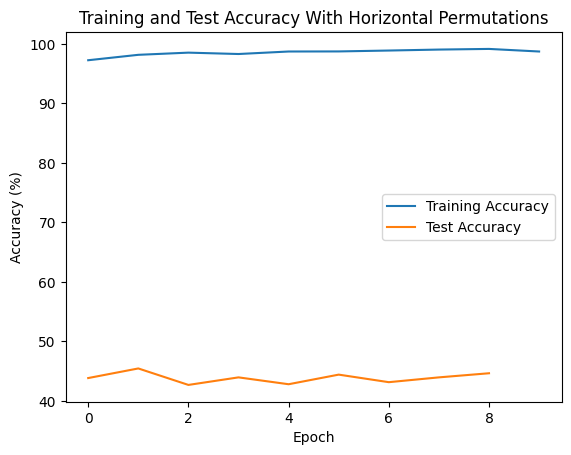

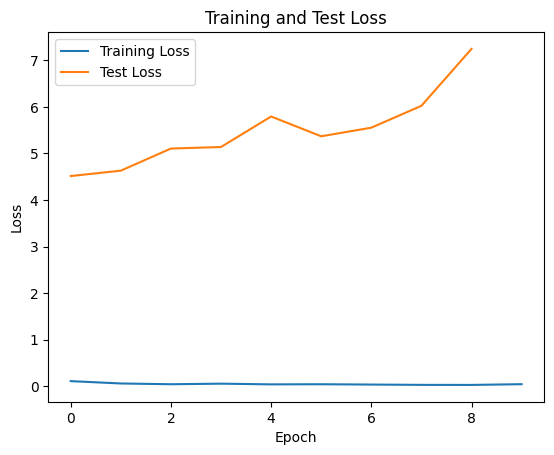

In [26]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure()
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy With Horizontal Permutations')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()